In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import pickle  # Added for pickle model saving
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Mount Google Drive (for Colab)
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Set your working directory path in Google Drive
# WORKING_DIR = "/content/enrollees_dataset.csv"  # Change this to your path
# os.chdir(WORKING_DIR)

# Create directory for saving models
MODEL_DIR = "prophet_models"
os.makedirs(MODEL_DIR, exist_ok=True)

# -----------------------------
# Load and prepare all data
# -----------------------------
csv_file_path = "/content/prophet_models/enrollees_dataset.csv"
data = pd.read_csv(csv_file_path)

print("📊 COMPREHENSIVE ENROLLMENT ANALYSIS")
print("=" * 50)
print(f"Dataset shape: {data.shape}")
print(f"Courses available: {data['Course'].unique()}")
print(f"Time period: {data['School_Year'].min()} to {data['School_Year'].max()}")
print(f"Total enrollment records: {len(data)}")

📊 COMPREHENSIVE ENROLLMENT ANALYSIS
Dataset shape: (56, 9)
Courses available: ['BSCS' 'BSIT' 'BSBA-MARKETING_MANAGEMENT' 'BSBA-FINANCIAL_MANAGEMENT']
Time period: 2018-2019 to 2024-2025
Total enrollment records: 56


In [10]:
# -----------------------------
# 1. Overall Enrollment Trends
# -----------------------------
# Convert to datetime and sort
data['Year'] = data['School_Year'].str.split('-').str[0].astype(int)
data['Semester_Num'] = data['Semester'].map({'1st': 1, '2nd': 2})
data = data.sort_values(['Year', 'Semester_Num'])

# Create time index for all data
data['time_index'] = range(len(data))

print(f"\n📈 OVERALL TRENDS:")
total_by_course = data.groupby('Course')['total_enrollees'].sum().sort_values(ascending=False)
print("Total enrollments by course:")
for course, total in total_by_course.items():
    print(f"  {course}: {total} students")


📈 OVERALL TRENDS:
Total enrollments by course:
  BSIT: 3791 students
  BSBA-FINANCIAL_MANAGEMENT: 2515 students
  BSBA-MARKETING_MANAGEMENT: 2488 students
  BSCS: 720 students


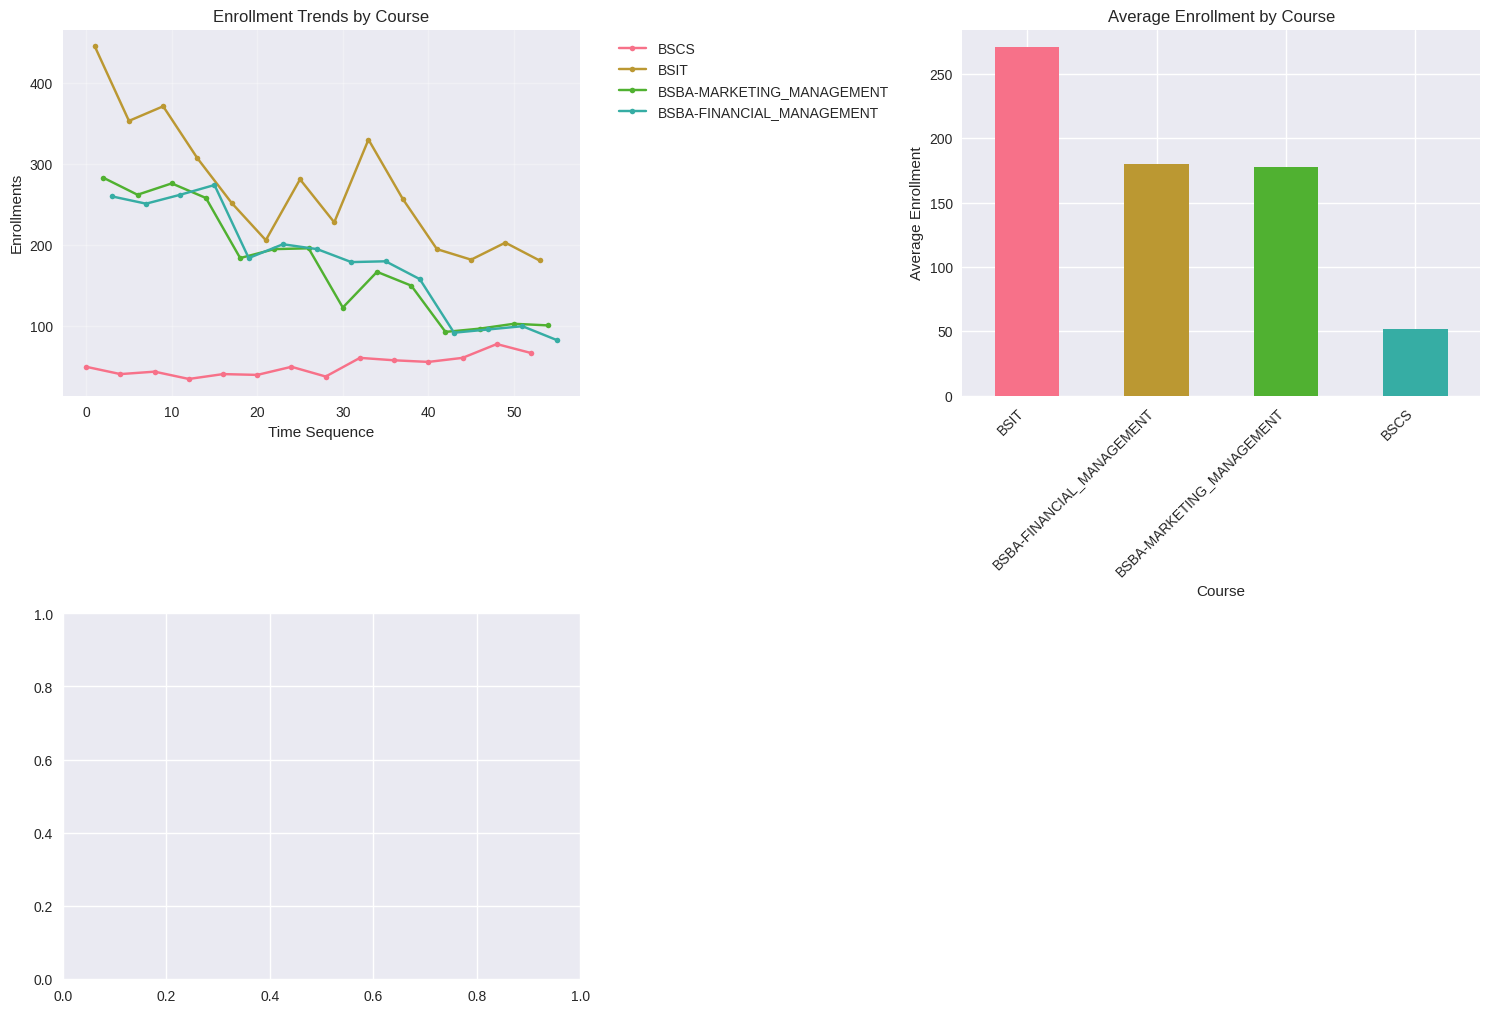

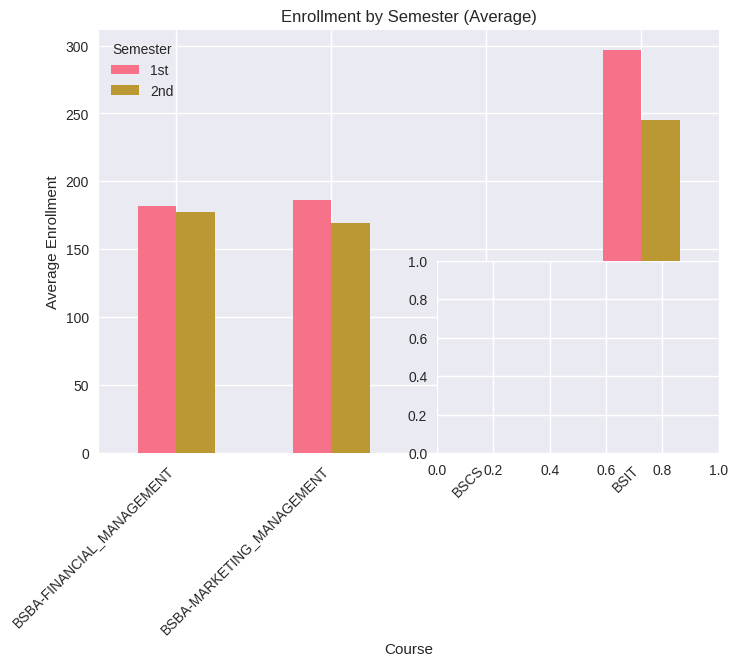

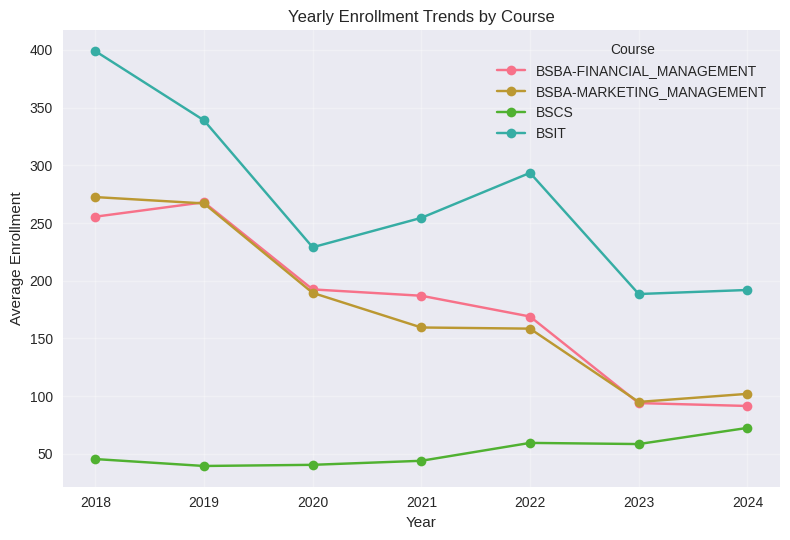

In [11]:
# -----------------------------
# 2. Comparative Analysis - All Courses
# -----------------------------
plt.figure(figsize=(15, 10))

# Enrollment trends by course over time
plt.subplot(2, 2, 1)
for course in data['Course'].unique():
    course_data = data[data['Course'] == course]
    plt.plot(course_data['time_index'], course_data['total_enrollees'],
             'o-', label=course, markersize=4)
plt.xlabel('Time Sequence')
plt.ylabel('Enrollments')
plt.title('Enrollment Trends by Course')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Average enrollment by course
plt.subplot(2, 2, 2)
avg_enrollment = data.groupby('Course')['total_enrollees'].mean().sort_values(ascending=False)
avg_enrollment.plot(kind='bar', color=sns.color_palette())
plt.title('Average Enrollment by Course')
plt.ylabel('Average Enrollment')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Semester comparison
plt.subplot(2, 2, 3)
semester_avg = data.groupby(['Course', 'Semester'])['total_enrollees'].mean().unstack()
semester_avg.plot(kind='bar')
plt.title('Enrollment by Semester (Average)')
plt.ylabel('Average Enrollment')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Semester')

# Yearly trends
plt.subplot(2, 2, 4)
yearly_trend = data.groupby(['Course', 'Year'])['total_enrollees'].mean().unstack().T
yearly_trend.plot(marker='o')
plt.title('Yearly Enrollment Trends by Course')
plt.ylabel('Average Enrollment')
plt.xlabel('Year')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [12]:
# -----------------------------
# 3. Forecasting for Multiple Courses
# -----------------------------
def forecast_course_enrollment(course_data, course_name, periods=4):
    """Forecast enrollment for a specific course and save the model as pickle"""
    # Prepare data for Prophet
    prophet_df = pd.DataFrame({
        "ds": pd.date_range(start="2018-01-01", periods=len(course_data), freq="6ME"),
        "y": course_data["total_enrollees"].values
    })

    # Create and fit Prophet model
    model = Prophet(
        yearly_seasonality=True,
        seasonality_mode='multiplicative',
        changepoint_prior_scale=0.05
    )
    model.fit(prophet_df)

    # Save the model as a pickle file
    model_file = os.path.join(MODEL_DIR, f"{course_name}_prophet_model.pkl")
    with open(model_file, 'wb') as f:
        pickle.dump(model, f)
    print(f"Saved model for {course_name} to {model_file}")

    # Make future forecast
    future = model.make_future_dataframe(periods=periods, freq="6ME")
    forecast = model.predict(future)

    # Calculate metrics
    y_true = prophet_df["y"].values
    y_pred = forecast.iloc[:len(y_true)]["yhat"].values

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100
    accuracy = 100 - mape
    r2 = r2_score(y_true, y_pred)

    return {
        'course': course_name,
        'model': model,
        'forecast': forecast,
        'actual': y_true,
        'predicted': y_pred,
        'mse': mse,
        'rmse': rmse,
        'mape': mape,
        'accuracy': accuracy,
        'r2': r2,
        'future_dates': forecast.iloc[len(y_true):]["ds"].values,
        'future_predictions': forecast.iloc[len(y_true):]["yhat"].values,
        'model_file': model_file
    }

# Forecast for each course
course_forecasts = {}
for course in data['Course'].unique():
    course_data = data[data['Course'] == course].sort_values(['Year', 'Semester_Num'])
    if len(course_data) >= 6:  # Only forecast if enough data
        forecast_result = forecast_course_enrollment(course_data, course)
        course_forecasts[course] = forecast_result

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 10.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvgfafpyi/enozaq87.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvgfafpyi/xljs135h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73851', 'data', 'file=/tmp/tmpvgfafpyi/enozaq87.json', 'init=/tmp/tmpvgfafpyi/xljs135h.json', 'output', 'file=/tmp/tmpvgfafpyi/prophet_model33x3m_lv/prophet_model-20250905082819.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
08:28:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:28:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:

Saved model for BSCS to prophet_models/BSCS_prophet_model.pkl


DEBUG:cmdstanpy:input tempfile: /tmp/tmpvgfafpyi/qgx9tb3u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvgfafpyi/0mc6rtyo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28381', 'data', 'file=/tmp/tmpvgfafpyi/qgx9tb3u.json', 'init=/tmp/tmpvgfafpyi/0mc6rtyo.json', 'output', 'file=/tmp/tmpvgfafpyi/prophet_modelx6kw05k5/prophet_model-20250905082820.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
08:28:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:28:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Saved model for BSIT to prophet_models/BSIT_prophet_model.pkl


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 10.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvgfafpyi/4ylx1ywa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvgfafpyi/ts3245fk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35238', 'data', 'file=/tmp/tmpvgfafpyi/4ylx1ywa.json', 'init=/tmp/tmpvgfafpyi/ts3245fk.json', 'output', 'file=/tmp/tmpvgfafpyi/prophet_model2o7r8w2_/prophet_model-20250905082821.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
08:28:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:28:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:

Saved model for BSBA-MARKETING_MANAGEMENT to prophet_models/BSBA-MARKETING_MANAGEMENT_prophet_model.pkl


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 10.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvgfafpyi/vdj6hnwp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvgfafpyi/zjhm_89x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87541', 'data', 'file=/tmp/tmpvgfafpyi/vdj6hnwp.json', 'init=/tmp/tmpvgfafpyi/zjhm_89x.json', 'output', 'file=/tmp/tmpvgfafpyi/prophet_modeljlr5qiwp/prophet_model-20250905082821.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
08:28:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:28:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:

Saved model for BSBA-FINANCIAL_MANAGEMENT to prophet_models/BSBA-FINANCIAL_MANAGEMENT_prophet_model.pkl


In [13]:
# -----------------------------
# 4. Comparative Forecast Results
# -----------------------------
print("\n📊 FORECAST ACCURACY BY COURSE:")
print("=" * 50)
results = []
for course, result in course_forecasts.items():
    results.append({
        'Course': course,
        'MSE': result['mse'],
        'RMSE': result['rmse'],
        'MAPE': result['mape'],
        'Accuracy': result['accuracy'],
        'R2': result['r2'],
        'Data Points': len(result['actual']),
        'Model File': result['model_file']
    })

results_df = pd.DataFrame(results)
print(results_df.sort_values('Accuracy', ascending=False)[['Course', 'MSE', 'RMSE', 'MAPE', 'Accuracy', 'R2', 'Data Points', 'Model File']].to_string(index=False))


📊 FORECAST ACCURACY BY COURSE:
                   Course        MSE      RMSE      MAPE  Accuracy       R2  Data Points                                                 Model File
                     BSIT 666.945341 25.825285  9.648736 90.351264 0.890058           14                      prophet_models/BSIT_prophet_model.pkl
BSBA-FINANCIAL_MANAGEMENT 320.917786 17.914178  9.900176 90.099824 0.923559           14 prophet_models/BSBA-FINANCIAL_MANAGEMENT_prophet_model.pkl
                     BSCS  42.636422  6.529657 11.792648 88.207352 0.709311           14                      prophet_models/BSCS_prophet_model.pkl
BSBA-MARKETING_MANAGEMENT 412.995938 20.322301 12.529067 87.470933 0.909661           14 prophet_models/BSBA-MARKETING_MANAGEMENT_prophet_model.pkl


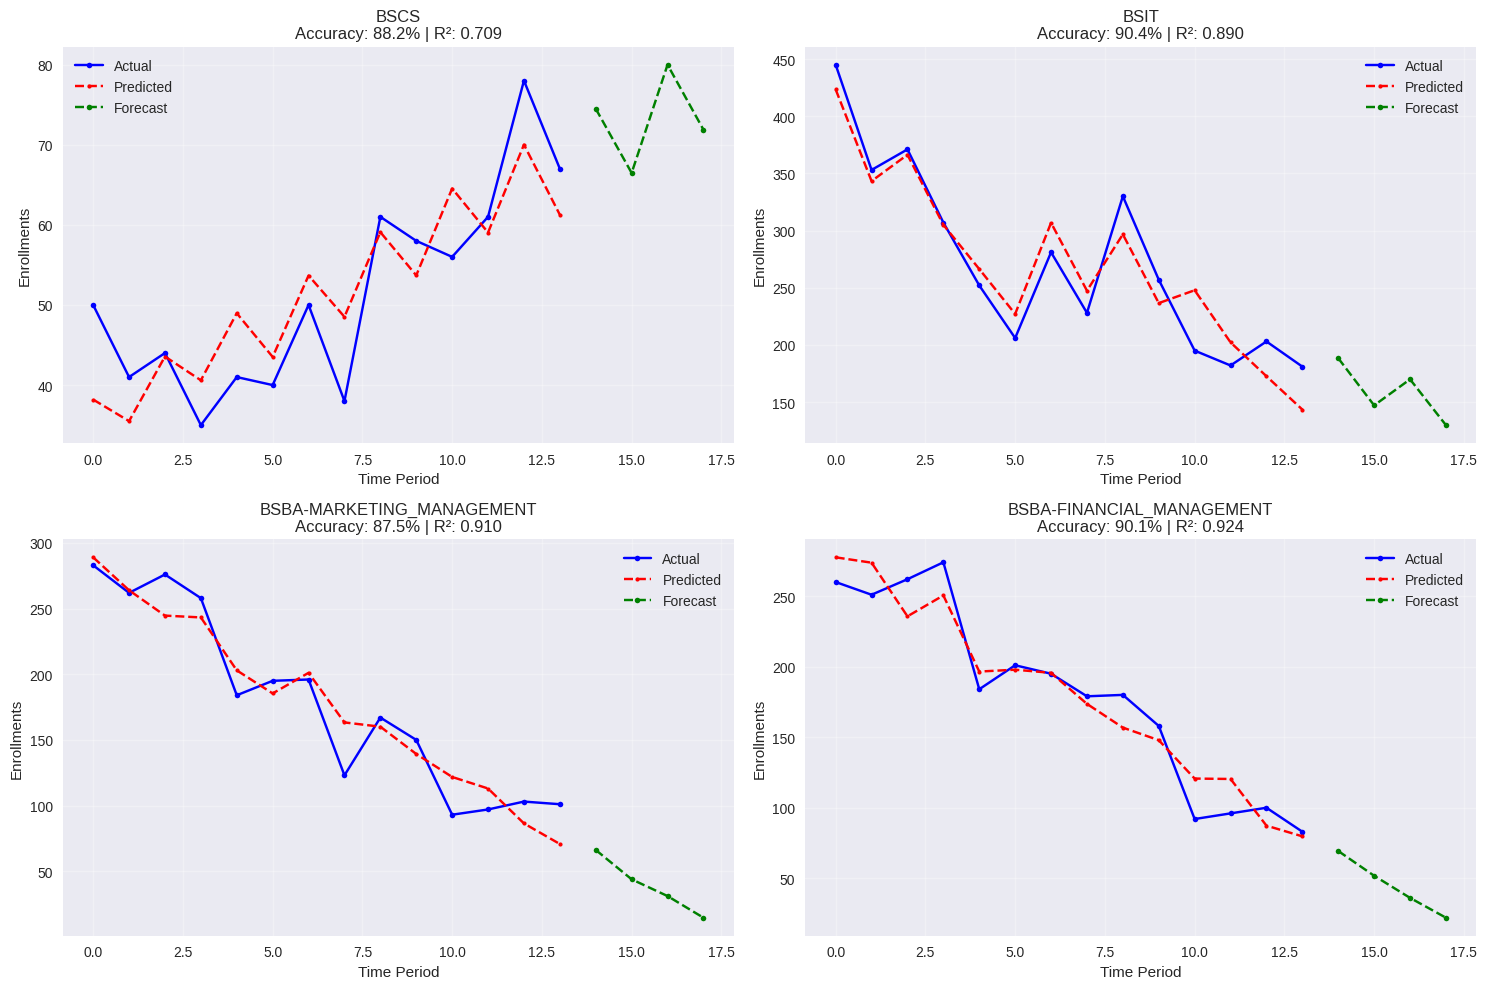

In [14]:
# -----------------------------
# 5. Visualize All Forecasts
# -----------------------------
plt.figure(figsize=(15, 10))
n_courses = len(course_forecasts)
colors = sns.color_palette("husl", n_courses)

for i, (course, result) in enumerate(course_forecasts.items()):
    plt.subplot(2, (n_courses+1)//2, i+1)

    # Plot historical data
    time_points = range(len(result['actual']))
    plt.plot(time_points, result['actual'], 'bo-', label='Actual', markersize=4)
    plt.plot(time_points, result['predicted'], 'ro--', label='Predicted', markersize=3)

    # Plot future forecast
    future_points = range(len(result['actual']), len(result['actual']) + len(result['future_predictions']))
    plt.plot(future_points, result['future_predictions'], 'go--', label='Forecast', markersize=4)

    plt.title(f'{course}\nAccuracy: {result["accuracy"]:.1f}% | R²: {result["r2"]:.3f}')
    plt.xlabel('Time Period')
    plt.ylabel('Enrollments')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [15]:
# -----------------------------
# 6. Future Predictions Summary
# -----------------------------
print("\n🔮 FUTURE ENROLLMENT PREDICTIONS (Next 2 Years):")
print("=" * 60)

future_predictions = []
for course, result in course_forecasts.items():
    for j, (date, pred) in enumerate(zip(result['future_dates'], result['future_predictions'])):
        # Convert numpy datetime64 to pandas datetime
        date_pd = pd.to_datetime(date)
        year = date_pd.year
        semester = "1st" if date_pd.month <= 6 else "2nd"
        school_year = f"{year}-{year+1}" if semester == "1st" else f"{year-1}-{year}"

        future_predictions.append({
            'School_Year': school_year,
            'Semester': semester,
            'Course': course,
            'Predicted_Enrollment': round(pred, 1),
            'Year': year
        })

# Create summary dataframe
future_df = pd.DataFrame(future_predictions)
future_df = future_df.sort_values(['Year', 'Course'])

# Pivot for better readability
pivot_df = future_df.pivot_table(
    values='Predicted_Enrollment',
    index=['School_Year', 'Semester'],
    columns='Course',
    aggfunc='first'
).reset_index()

print(pivot_df.round(1).to_string(index=False))


🔮 FUTURE ENROLLMENT PREDICTIONS (Next 2 Years):
School_Year Semester  BSBA-FINANCIAL_MANAGEMENT  BSBA-MARKETING_MANAGEMENT  BSCS  BSIT
  2024-2025      2nd                       51.8                       43.8  66.5 147.1
  2025-2026      1st                       69.3                       66.2  74.5 188.4
  2025-2026      2nd                       22.0                       14.5  71.9 129.8
  2026-2027      1st                       36.1                       31.0  80.0 169.9


In [16]:
# -----------------------------
# 7. Growth Rate Analysis
# -----------------------------
print("\n📈 PREDICTED GROWTH RATES:")
growth_rates = []
for course, result in course_forecasts.items():
    current_avg = np.mean(result['actual'][-4:])  # Average of last 2 years
    future_avg = np.mean(result['future_predictions'])  # Average of next 2 years
    growth = ((future_avg - current_avg) / current_avg) * 100

    growth_rates.append({
        'Course': course,
        'Current_Avg': round(current_avg, 1),
        'Future_Avg': round(future_avg, 1),
        'Growth_Rate': round(growth, 1)
    })

growth_df = pd.DataFrame(growth_rates).sort_values('Growth_Rate', ascending=False)
print(growth_df.to_string(index=False))



📈 PREDICTED GROWTH RATES:
                   Course  Current_Avg  Future_Avg  Growth_Rate
                     BSCS         65.5        73.2         11.8
                     BSIT        190.2       158.8        -16.5
BSBA-FINANCIAL_MANAGEMENT         92.8        44.8        -51.7
BSBA-MARKETING_MANAGEMENT         98.5        38.9        -60.5


In [17]:
# -----------------------------
# 8. Enhanced Scholarship Impact Analysis
# -----------------------------
print("\n💰 ENHANCED SCHOLARSHIP IMPACT ANALYSIS:")
# Convert scholarship to boolean
data['scholarship_bool'] = data['scholarship'] == 'yes'

# Calculate average enrollment by scholarship status and semester
scholarship_impact = data.groupby(['Course', 'scholarship', 'Semester']).agg({
    'total_enrollees': 'mean',
    '1st_year_enrollees': 'mean'
}).round(1).unstack('Semester')

print("Average enrollment with vs without scholarships by semester:")
print(scholarship_impact.to_string())

# Calculate percentage impact
print("\nPercentage impact of scholarships by course:")
scholarship_effects = []
for course in data['Course'].unique():
    course_scholarship = data[data['Course'] == course].groupby('scholarship')['total_enrollees'].mean()
    if 'yes' in course_scholarship and 'no' in course_scholarship:
        with_scholarship = course_scholarship['yes']
        without_scholarship = course_scholarship['no']
        impact = ((with_scholarship - without_scholarship) / without_scholarship) * 100
        scholarship_effects.append({
            'Course': course,
            'With_Scholarship': round(with_scholarship, 1),
            'Without_Scholarship': round(without_scholarship, 1),
            'Impact (%)': round(impact, 1)
        })

scholarship_effects_df = pd.DataFrame(scholarship_effects).sort_values('Impact (%)', ascending=False)
print(scholarship_effects_df.to_string(index=False))


💰 ENHANCED SCHOLARSHIP IMPACT ANALYSIS:
Average enrollment with vs without scholarships by semester:
                                      total_enrollees        1st_year_enrollees      
Semester                                          1st    2nd                1st   2nd
Course                    scholarship                                                
BSBA-FINANCIAL_MANAGEMENT no                    182.0  251.0               46.5  54.0
                          yes                   181.8  165.2               67.8  33.7
BSBA-MARKETING_MANAGEMENT no                    160.0  258.0               46.2  62.0
                          yes                   220.7  154.7               94.7  39.8
BSCS                      no                     52.7   46.3               18.7  17.0
                          yes                    55.5   50.2               24.0  12.0
BSIT                      no                    242.7  267.2               80.3  76.8
                          yes         

In [18]:
# -----------------------------
# 9. Correlation Analysis (Updated)
# -----------------------------
print("\n📊 CORRELATION ANALYSIS (Updated):")
correlation_data = data.groupby(['Course', 'School_Year', 'Semester']).agg({
    'total_enrollees': 'first',
    'scholarship_bool': 'first',
    '1st_year_enrollees': 'first'
}).reset_index()

correlation_matrix = correlation_data[['total_enrollees', 'scholarship_bool', '1st_year_enrollees']].corr()
print("Correlation matrix:")
print(correlation_matrix.round(3))


📊 CORRELATION ANALYSIS (Updated):
Correlation matrix:
                    total_enrollees  scholarship_bool  1st_year_enrollees
total_enrollees               1.000            -0.015               0.803
scholarship_bool             -0.015             1.000               0.056
1st_year_enrollees            0.803             0.056               1.000


In [19]:
# -----------------------------
# 10. Strategic Recommendations
# -----------------------------
print("\n💡 STRATEGIC RECOMMENDATIONS:")
print("=" * 50)

# Based on growth rates
print("1. GROWTH POTENTIAL:")
for _, row in growth_df.iterrows():
    trend = "↑" if row['Growth_Rate'] > 0 else "↓"
    print(f"   {row['Course']}: {trend} {abs(row['Growth_Rate'])}% growth potential")

# Based on scholarship impact
print("\n2. SCHOLARSHIP EFFECTIVENESS:")
for _, row in scholarship_effects_df.iterrows():
    effect = "increases" if row['Impact (%)'] > 0 else "decreases"
    print(f"   {row['Course']}: Scholarships {effect} enrollment by {abs(row['Impact (%)']):.1f}%")



💡 STRATEGIC RECOMMENDATIONS:
1. GROWTH POTENTIAL:
   BSCS: ↑ 11.8% growth potential
   BSIT: ↓ 16.5% growth potential
   BSBA-FINANCIAL_MANAGEMENT: ↓ 51.7% growth potential
   BSBA-MARKETING_MANAGEMENT: ↓ 60.5% growth potential

2. SCHOLARSHIP EFFECTIVENESS:
   BSIT: Scholarships increases enrollment by 11.0%
   BSCS: Scholarships increases enrollment by 6.8%
   BSBA-MARKETING_MANAGEMENT: Scholarships decreases enrollment by 1.6%
   BSBA-FINANCIAL_MANAGEMENT: Scholarships decreases enrollment by 15.7%


In [20]:
# -----------------------------
# 11. Save all models and results for future use
# -----------------------------
# Save the complete forecasting results
with open(os.path.join(MODEL_DIR, 'all_forecasts.pkl'), 'wb') as f:
    pickle.dump(course_forecasts, f)

# Save the results dataframe
results_df.to_csv(os.path.join(MODEL_DIR, 'forecast_accuracy_results.csv'), index=False)

print(f"\n✅ All models and results saved to {MODEL_DIR} directory")


✅ All models and results saved to prophet_models directory
